# Libraries

In [112]:
import datetime
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# State Space Solver Class

In [111]:
class StateSpace():
    def __init__(self,A,B,C,D,x0,dt):        
        #state space matrices
        assert A.shape[0]!=A.shape[1] , "A must be square matrix"
        assert x0.shape!=[A.shape[0],1], "Initial state must have shape " + str([A.shape[0],1])
        assert A.shape[0]!=B.shape[0] , "A and B must have same rows number"
        assert C.shape[0]!=D.shape[0] , "C and D must have same rows number"
        assert C.shape[1]!=A.shape[1] , "A and C must have same coulmns number"
        assert B.shape[1]!=D.shape[1] , "A and C must have same coulmns number"

        self.A = A 
        self.B = B 
        self.C = C
        self.D = D
        self.dt = dt
        #to ease calculations in every iteration
        self.__inv__ = np.linalg.inv(np.eye(A.shape[0])-A*dt)
        #loggers
        self.x=[x0]
        self.y=[]
        self.u=[]
        
    def reset(self,x0):        
        #loggers
        self.x=[x0]
        self.y=[]
        self.u=[]

    def step(self,u):
        self.u.append(u)
        self.x.append( np.dot(self.__inv__ , (np.dot( self.B*self.dt,u)+self.x[-1]) ) )
        self.y.append(self.C.dot(self.x[-1])+self.D.dot(u))
 
    def solve(self,U):
        for u in U: self.step(u)

    def plot(self, input_labels=None, labels=None, plot_state=True):
        if labels==None :       output_labels = ['Output'+str(i) for i in range(self.C.shape[0])] 
        if input_labels==None : input_labels  = ['input'+str(i) for i in range(self.B.shape[1])]  
 
        Time    = np.arange(0,len(self.y)*dt,dt)
        inputs  = np.array(self.u).T.reshape(-1,len(self.u))
        outputs = np.array(self.y).T.reshape(-1,len(self.y))

        for inp,label in zip(inputs,input_labels):          
            plt.plot(Time,inp ,'b', label =  label )
            plt.xlabel("time (s)")
            plt.ylabel(inplabel)
            plt.grid(1)
            if legend: plt.legend()
            plt.show()

        for op,label in zip(outputs,input_labels):          
            plt.plot(Time,inp ,'r', label =  label )
            plt.xlabel("time (s)")
            plt.ylabel(inplabel)
            plt.grid(1)
            if legend: plt.legend()
            plt.show()
        
        if plot_state:
           state_labels  = ['state'+str(i) for i in range(self.A.shape[0])]  
           state = np.array(self.x).T.reshape(-1,len(self.x)) 
           for st,label in zip(state,state_labels):          
               plt.plot(Time,inp ,'r', label =  label )
               plt.xlabel("time (s)")
               plt.ylabel(inplabel)
               plt.grid(1)
               if legend: plt.legend()
               plt.show()

    def get_output(self):
      return np.array(self.y)

    def get_state(self):
      return np.array(self.x)

    def get_input(self):
      return np.array(self.u)


    def get_matrix(self):
        x = np.array(self.X).reshape(len(self.X),self.X[0].shape[0],1)
        y = np.dot(self.C,x.T.reshape(-1,len(self.X))).T.reshape(len(self.X),self.C.shape[0],1)
        return x,y

# System Identification Class

In [50]:
class SysIden():
  def __init__(self,input_size,output_size,dt,learning_rate=5e-2):
    self.output_size = output_size
    self.input_size  = input_size
    self.dt_c = tf.constant(dt)
    self.Av = tf.Variable(tf.random_normal([output_size, output_size]))
    self.Bv = tf.Variable(tf.random_normal([output_size,  input_size]))

    self.y0 = tf.placeholder(tf.float32,[output_size,None])
    self.y = tf.placeholder(tf.float32, [output_size,None])
    self.u = tf.placeholder(tf.float32, [input_size,None])

    self.sess =  tf.Session()

    eye = tf.eye(output_size)
    temp0 = eye - self.Av * self.dt_c
    temp1 = tf.linalg.inv( temp0 )
    temp2 = tf.keras.backend.dot(self.Bv*self.dt_c,self.u) + self.y0
    y_ = tf.keras.backend.dot( temp1 , temp2) 

    self.cost = tf.reduce_mean(tf.losses.mean_squared_error(self.y, y_))
    self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
   
  def set_learning_rate(self,lrarning_rate):
    self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)
    

  def optimize(self,Y,U,iters=500,verbose=50):
    assert Y.shape[0] == self.output_size , "Training data output must be in size (output_shape,-1)"
    assert U.shape[0] == self.input_size  , "Training data  input must be in size  (input_shape,-1)"
    
    Y0 = Y[:,:-1]
    Y1 = Y[:,1:]

    costs = []

    self.sess.run(tf.global_variables_initializer())

    anow = datetime.datetime.now()
    now = datetime.datetime.now()
        
    try:    
        for it in range(iters):
          _, tk = self.sess.run([self.optimizer, self.cost], feed_dict = {self.y0:Y0 , self.y:Y1 , self.u:U})
          costs.append(tk)
          if it%verbose==0 and verbose!=-1:
              print(it,": cost =", "{:.16f}".format(tk)," took: ",datetime.datetime.now() - now)
              now = datetime.datetime.now()

    except KeyboardInterrupt: pass            
    print("\nTraining complete!"," took: ",datetime.datetime.now() - anow)
    plt.plot(costs)
    plt.xlabel("Iterations")
    plt.ylabel("Cost")
    plt.grid(1)
    plt.show()


  def get_matrices(self):
    return self.sess.run(self.Av), self.sess.run(self.Bv)





# Testing & Results

### Time

In [51]:
start_time,end_time,dt = 0,100,0.001
Time =  np.arange(start_time,end_time,dt)

### DC Motor

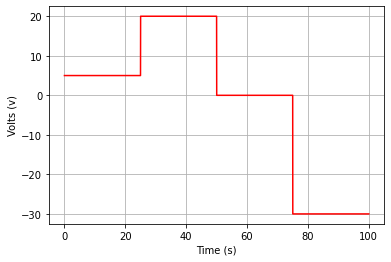

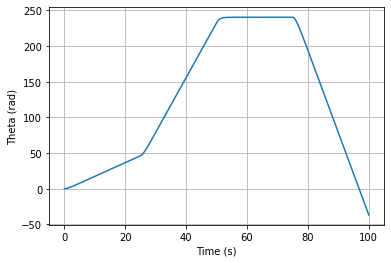

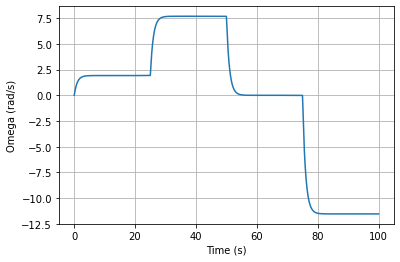

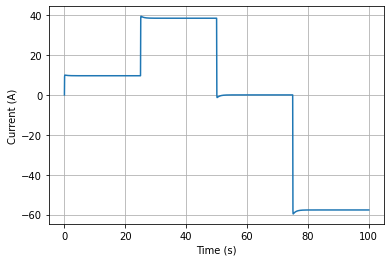

In [82]:
#model constants
R,L,K,J,B = 0.5,1.2e-2,0.1,0.5 ,0.5

#inputs
temp = int(len(Time)/4)
U =  np.concatenate( (5*np.ones((temp,1)) ,20*np.ones((temp,1)) ,np.zeros((temp,1)) ,-30*np.ones((temp,1))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) 
#plotting input 
plt.plot(Time,U,"r")
plt.xlabel("Time (s)")
plt.ylabel("Volts (v)")
plt.grid(1)
plt.show()

#state space matrices
A =  np.array([[0,  1,    0],
               [0,-B/J, K/J],
               [0,-K/L,-R/L]])
B = np.array([[0],
              [0],
              [1/L]])
C = np.eye(3)
D = np.zeros((3,1))

#running the model 
system = signal.lti(A,B,C,D)
_,Y, _ = signal.lsim2(system, U, Time)
#plotting system outputs
labels =['Theta (rad)','Omega (rad/s)',"Current (A)"]
for y,label in zip(Y.T,labels):
    plt.plot(Time,y)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.show()

#preparing the data for identification Y shape :(len(time) +1<-- for initial conditions,-1) , U shape :(len(time),-1) 
ics = np.zeros((1,Y.shape[-1]))
Y = np.concatenate((ics,Y),axis=0).T
U = U.T

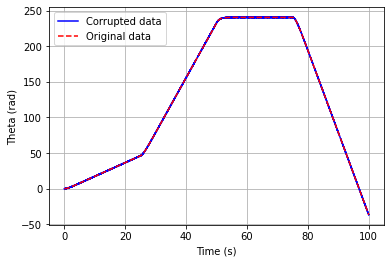

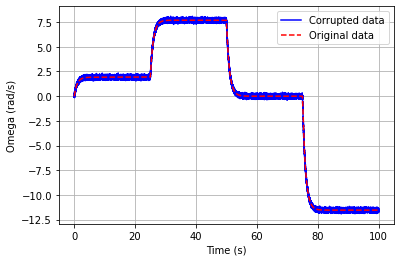

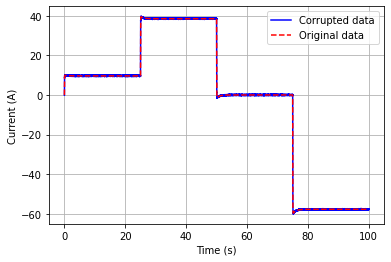

0 : cost = 0.0256203878670931  took:  0:00:00.054914
50 : cost = 0.0155449574813247  took:  0:00:00.279668
100 : cost = 0.0153102213516831  took:  0:00:00.238250
150 : cost = 0.0152421481907368  took:  0:00:00.256572
200 : cost = 0.0151731008663774  took:  0:00:00.238816
250 : cost = 0.0151055017486215  took:  0:00:00.240435
300 : cost = 0.0150420153513551  took:  0:00:00.239059
350 : cost = 0.0149843068793416  took:  0:00:00.252065
400 : cost = 0.0149332210421562  took:  0:00:00.251533
450 : cost = 0.0148889971897006  took:  0:00:00.242318
500 : cost = 0.0148514481261373  took:  0:00:00.241849
550 : cost = 0.0148201221600175  took:  0:00:00.240116
600 : cost = 0.0147943943738937  took:  0:00:00.261009
650 : cost = 0.0147735821083188  took:  0:00:00.257637
700 : cost = 0.0147569822147489  took:  0:00:00.250094
750 : cost = 0.0147439278662205  took:  0:00:00.253766
800 : cost = 0.0147337894886732  took:  0:00:00.267955
850 : cost = 0.0147260250523686  took:  0:00:00.246843
900 : cost = 

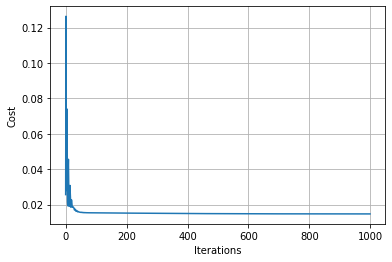

In [83]:
#Optimization Session (You would need to only edit epochs, noise level, Lr)  

iters = 1000
noise_levels = np.array([0.05,0.1,0.1]).reshape(3,-1)
lr = 2.5
noise  = np.random.randn(*Y.shape) * noise_levels
Yn= Y+ noise
for s,s_,label in zip(Y[:,1:],Yn[:,1:],labels):
    plt.plot(Time,s_,'b',label='Corrupted data')
    plt.plot(Time,s,'r--',label='Original data')
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.legend()
    plt.show()

#build the system identifier object
oshp,ishp = Y.shape[0], U.shape[0]
iden = SysIden(ishp,oshp,dt,lr)

iden.optimize(Yn,U,1000)



(100000, 3)
(3, 100000) (3, 100000)


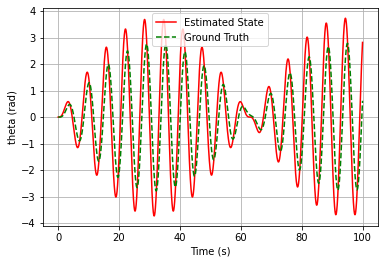

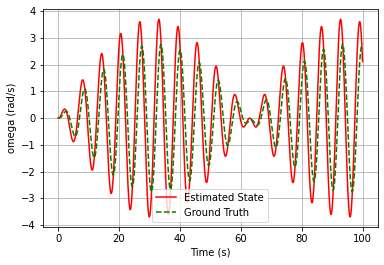

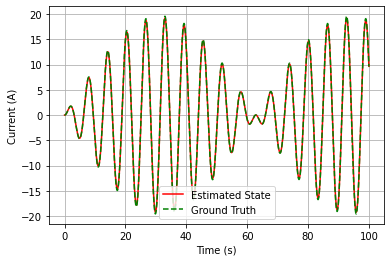

In [84]:
#Results Showing (you would only need to change the input vector)

temp = int(len(Time)/4)
#U =  np.concatenate( ([0],5*np.ones((temp-1,)) ,20*np.ones((temp,)) ,np.zeros((temp,)) ,-30*np.ones((temp,))) )
U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) #(length, no. of inputs, size of input)

A,B = iden.get_matrices()
C = np.eye(3)
D = np.zeros((3,1))
system1 = signal.lti(A,B,C,D)

_, X_new, _ = signal.lsim2(system1, U, Time)
_, X_old, _ = signal.lsim2(system, U, Time)

ploting1,ploting2 = X_old.T, X_new.T
for q,w,name in zip(ploting1,ploting2,labels):
  plt.plot(Time,w,'r', label='Estimated State')
  plt.plot(Time,q,'g--',label='Ground Truth')
  plt.xlabel("Time (s)")
  plt.ylabel(name)
  plt.legend()
  plt.grid(1)
  plt.show()

### assumption violating model 

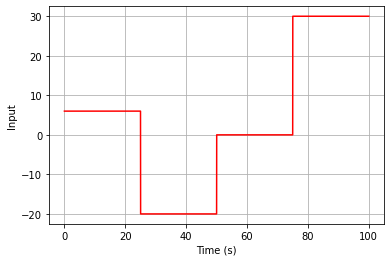

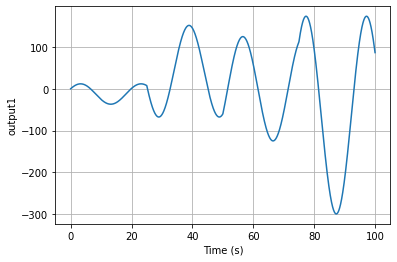

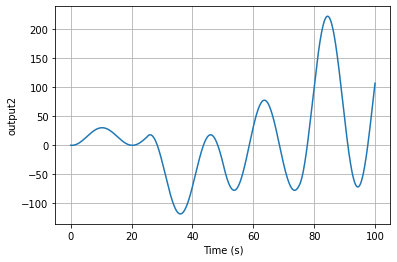

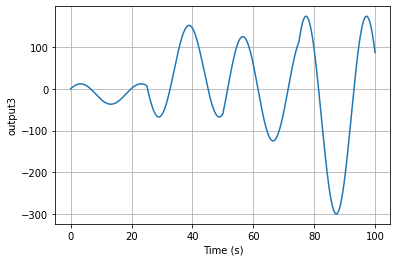

In [86]:
#inputs
temp = int(len(Time)/4)
U =  np.concatenate( (6*np.ones((temp,1)) ,-20*np.ones((temp,1)) ,np.zeros((temp,1)) ,30*np.ones((temp,1))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) 
#plotting input 
plt.plot(Time,U,"r")
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.grid(1)
plt.show()

#state space matrices
A = np.array([[0,-0.2],[0.5,0]])
B = np.array([[5],[-1]])
C = np.array([[0.2,-0.1],[0,0.1],[0.2,-0.1]])
D = np.zeros((3,1))

#running the model 
system = signal.lti(A,B,C,D)
_,Y, _ = signal.lsim2(system, U, Time)
#plotting system outputs
labels = ['output1','output2','output3']
for y,label in zip(Y.T,labels):
    plt.plot(Time,y)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.show()

#preparing the data for identification Y shape :(len(time) +1<-- for initial conditions,-1) , U shape :(len(time),-1) 
ics = np.zeros((1,Y.shape[-1]))
Y = np.concatenate((ics,Y),axis=0).T
U = U.T


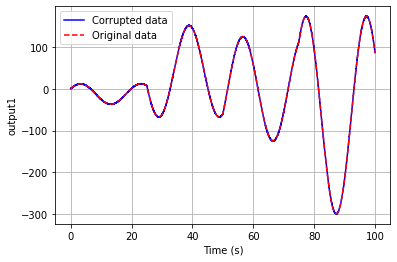

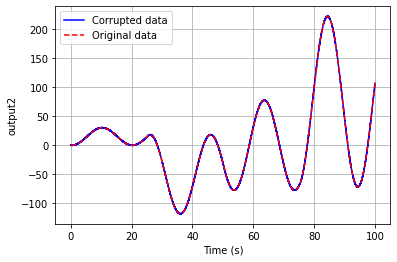

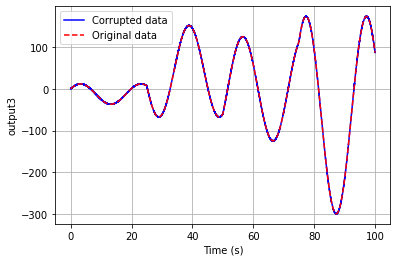

0 : cost = 0.0295045580714941  took:  0:00:00.056895
50 : cost = 0.0158899482339621  took:  0:00:00.247523
100 : cost = 0.0149935511872172  took:  0:00:00.249046
150 : cost = 0.0149885872378945  took:  0:00:00.236519
200 : cost = 0.0149880014359951  took:  0:00:00.265022
250 : cost = 0.0149873597547412  took:  0:00:00.241741
300 : cost = 0.0149866491556168  took:  0:00:00.244394
350 : cost = 0.0149858659133315  took:  0:00:00.243652
400 : cost = 0.0149850146844983  took:  0:00:00.247053
450 : cost = 0.0149840964004397  took:  0:00:00.247879
500 : cost = 0.0149831119924784  took:  0:00:00.240130
550 : cost = 0.0149820670485497  took:  0:00:00.261796
600 : cost = 0.0149809550493956  took:  0:00:00.267899
650 : cost = 0.0149797881022096  took:  0:00:00.235807
700 : cost = 0.0149785596877337  took:  0:00:00.253062
750 : cost = 0.0149772642180324  took:  0:00:00.240669
800 : cost = 0.0149759110063314  took:  0:00:00.296960
850 : cost = 0.0149744935333729  took:  0:00:00.246833
900 : cost = 

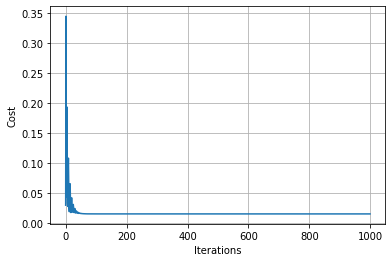

In [87]:
#Optimization Session (You would need to only edit epochs, noise level, Lr)  

iters = 1000
noise_levels = np.array([0.05,0.1,0.1]).reshape(3,-1)
lr = 2.5
noise  = np.random.randn(*Y.shape) * noise_levels
Yn= Y+ noise
labels = ['output1','output2','output3']
for s,s_,label in zip(Y[:,1:],Yn[:,1:],labels):
    plt.plot(Time,s_,'b',label='Corrupted data')
    plt.plot(Time,s,'r--',label='Original data')
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.legend()
    plt.show()

#build the system identifier object
oshp,ishp = Y.shape[0], U.shape[0]
iden = SysIden(ishp,oshp,dt,lr)

iden.optimize(Yn,U,1000)

(100000, 3)
(3, 100000) (3, 100000)


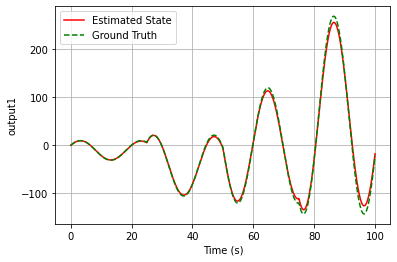

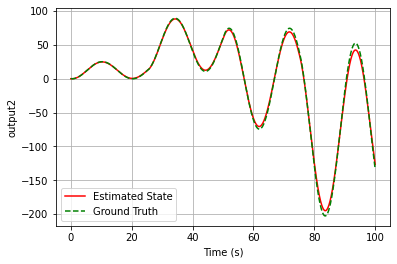

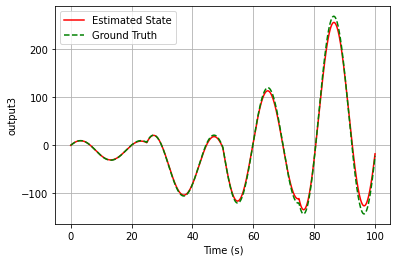

In [89]:
#Results Showing (you would only need to change the input vector)

temp = int(len(Time)/4)
U =  np.concatenate( ([[0]],5*np.ones((temp-1,1)) ,20*np.ones((temp,1)) ,np.zeros((temp,1)) ,-30*np.ones((temp,1))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
#U = U.reshape(len(Time), 1 ) 

A,B = iden.get_matrices()
C = np.eye(3)
D = np.zeros((3,1))
system1 = signal.lti(A,B,C,D)

_, X_new, _ = signal.lsim2(system1, U, Time)
_, X_old, _ = signal.lsim2(system, U, Time)

ploting1,ploting2 = X_old.T, X_new.T

for q,w,name in zip(ploting1,ploting2,labels):
  plt.plot(Time,w,'r', label='Estimated State')
  plt.plot(Time,q,'g--',label='Ground Truth')
  plt.xlabel("Time (s)")
  plt.ylabel(name)
  plt.legend()
  plt.grid(1)
  plt.show()

### Mass, Spring, Damper

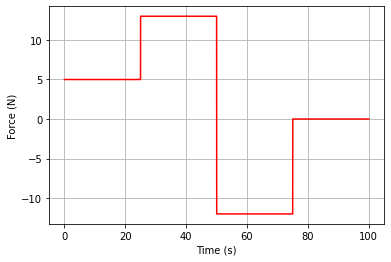

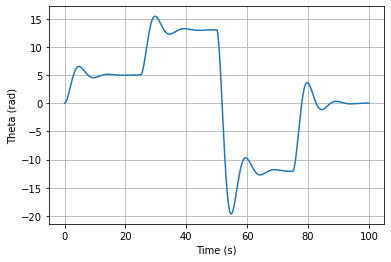

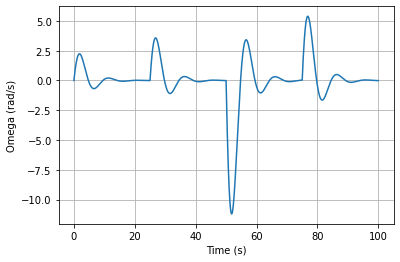

In [104]:
#parameters
k,b,m=1,1,2

#inputs
temp = int(len(Time)/4)
U =  np.concatenate( (5*np.ones((temp,)),13*np.ones((temp,)),-12*np.ones((temp,)) ,np.zeros((temp,))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
U = U.reshape(len(Time), 1 ) 
#plotting input 
plt.plot(Time,U,"r")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.grid(1)
plt.show()

#state space matrices
A = np.array([[0,1],[-k/m,-b/m]])
B = np.array([[0],[1/m]])
C = np.eye(2)
D = np.zeros((2,1))

#running the model 
system = signal.lti(A,B,C,D)
_,Y, _ = signal.lsim2(system, U, Time)
#plotting system outputs
labels = ['Theta (rad)','Omega (rad/s)']
for y,label in zip(Y.T,labels):
    plt.plot(Time,y)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.show()

#preparing the data for identification Y shape :(len(time) +1<-- for initial conditions,-1) , U shape :(len(time),-1) 
ics = np.zeros((1,Y.shape[-1]))
Y = np.concatenate((ics,Y),axis=0).T
U = U.T

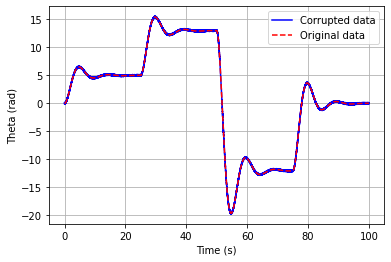

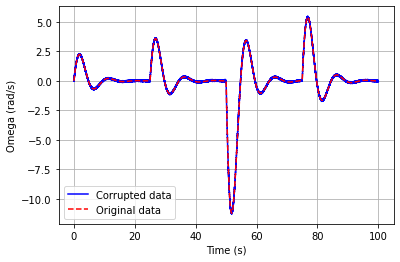

0 : cost = 0.0032648644410074  took:  0:00:00.066090
50 : cost = 0.0031405612826347  took:  0:00:00.203479
100 : cost = 0.0031259683892131  took:  0:00:00.208422
150 : cost = 0.0031259057577699  took:  0:00:00.200323
200 : cost = 0.0031259048264474  took:  0:00:00.211446
250 : cost = 0.0031259045936167  took:  0:00:00.197236
300 : cost = 0.0031259045936167  took:  0:00:00.212301
350 : cost = 0.0031259045936167  took:  0:00:00.207146
400 : cost = 0.0031259048264474  took:  0:00:00.210935
450 : cost = 0.0031259048264474  took:  0:00:00.215702
500 : cost = 0.0031259048264474  took:  0:00:00.207451
550 : cost = 0.0031259048264474  took:  0:00:00.212926
600 : cost = 0.0031259045936167  took:  0:00:00.223900
650 : cost = 0.0031259048264474  took:  0:00:00.218371
700 : cost = 0.0031259048264474  took:  0:00:00.207025
750 : cost = 0.0031259048264474  took:  0:00:00.206214
800 : cost = 0.0031259048264474  took:  0:00:00.225510
850 : cost = 0.0031259048264474  took:  0:00:00.228345
900 : cost = 

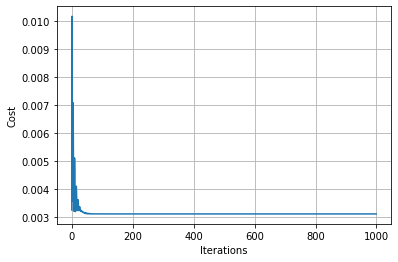

In [105]:
#Optimization Session (You would need to only edit epochs, noise level, Lr)  

iters = 1000
noise_levels = np.array([0.05,0.025]).reshape(2,-1)
lr = 5
noise  = np.random.randn(*Y.shape) * noise_levels
Yn= Y+ noise
for s,s_,label in zip(Y[:,1:],Yn[:,1:],labels):
    plt.plot(Time,s_,'b',label='Corrupted data')
    plt.plot(Time,s,'r--',label='Original data')
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(1)
    plt.legend()
    plt.show()

#build the system identifier object
oshp,ishp = Y.shape[0], U.shape[0]
iden = SysIden(ishp,oshp,dt,lr)

iden.optimize(Yn,U,1000)

(100000, 2)
(2, 100000) (2, 100000)


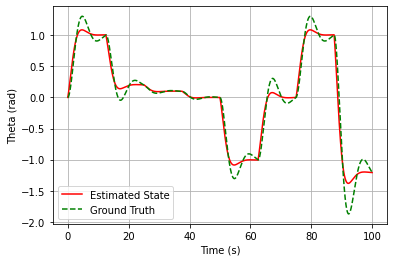

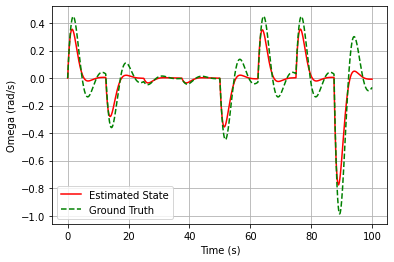

In [106]:
#Results Showing (you would only need to change the input vector)

temp = int(len(Time)/8)
U =  np.concatenate( (np.ones((temp,)),0.2*np.ones((temp,)),0.1*np.ones((temp,)) ,np.zeros((temp,)),-1*np.ones((temp,)),np.zeros((temp,)) ,1*np.ones((temp,)) ,-1.2*np.ones((temp,))) )
#U = 10*np.sin(0.05*Time)*np.sin(Time)
#U = U.reshape(len(Time), 1 ) 

A,B = iden.get_matrices()
C = np.eye(2)
D = np.zeros((2,1))
system1 = signal.lti(A,B,C,D)

_, X_new, _ = signal.lsim2(system1, U, Time)
_, X_old, _ = signal.lsim2(system, U, Time)

ploting1,ploting2 = X_old.T, X_new.T
for q,w,name in zip(ploting1,ploting2,labels):
  plt.plot(Time,w,'r', label='Estimated State')
  plt.plot(Time,q,'g--',label='Ground Truth')
  plt.xlabel("Time (s)")
  plt.ylabel(name)
  plt.legend()
  plt.grid(1)
  plt.show()